# Exp9. Chest Xray
## 1. Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드 시 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보자. 
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 로드

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- 비율은 각각 89%, 10.7%, 0.3%다. val 개수가 너무 적기 때문에 train에서 val에 쓰일 데이터를 더 가져와보자. 

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다. 
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다. 
train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person260_virus_541.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0775-0001.jpeg


In [6]:
# 파일 경로에 NORMAL이 있는지, 혹은 PNEUMONIA가 있는지 화깅낳면 정상 이미지와 폐렴 이미지를 셀 수 있다. 
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1077
Pneumonia images count in training set: 3108


- 정상보다 폐렴 이미지 수가 3배 더 많다. CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘한다. 데이터가 클래스 불균형한 것은 차후에 조정할 예정이다. 
- test와 val 데이터셋은 평가하기 위해서 사용하기 때문에 imbalance한 데이터셋이어도 문제가 없다. 

In [7]:
# tf.data 인스터스 생성, tf.data는 tensorflow에서 학습시킬 때, mini_batch로 작업할 수 있도록 해 준다. 
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없다. 
- 파일 경로를 이용해 라벨 데이터를 만들어주는 함수를 만들자. 

In [9]:
# 파일 경로의 끝에서 두 번째 부분을 확인하면 양성과 음성을 구분할 수 있다. 
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"  # 폐렴이면 True, 노말이며 False

- 이미지 데이터는 현실적으로 사이즈가 제각각일 확률이 높다. 
- 이미지의 사이즈를 통일시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여보자. 

In [10]:
# 이미지를 알맞은 형식으로 바꾼다. 
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨 읽어온다.
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)  # 이미지를 알맞은 형식으로 수정
    return img, label

- train, validation 데이터셋을 만든다. 
- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE 변수를 이용하면 더욱 빠르게 데이터를 처리해 줄 수 있다. 

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test 데이터셋 생성 및 데이터 개수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- TensorFlow에서는 tf.data 파이프라인을 사용해 학습 데이터를 효율적으로 사용할 수 있도록 해준다. 
- tf.data 파이프라인을 이용해 prepare_for_training() 함수를 정의해서 데이터를 변환해보자. 
- shuffle() : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
- repeat() : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, repeat()을 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다. 
- batch() : BATCH_SIZE에서 정한만큼의 배치로 주어진다. 
- prefetch() : 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스 유휴를 줄인다. 

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전한다. 
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었다.
    #ds = ds.map(
            #augment,       # augment 함수 적용
            #num_parallel_calls=2
        #)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
train에 있는 batch 중 첫 번째 배치를 추출한다. 추출된 배치를 image와 label 데이터셋으로 나눈다. 

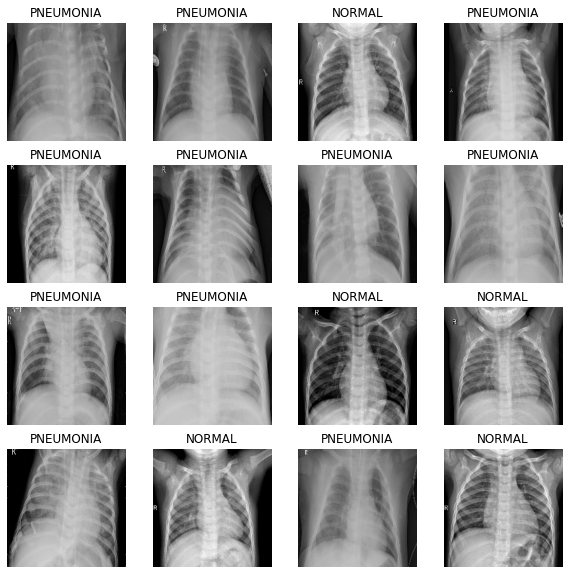

In [15]:
# 이미지 배치를 입력하면 여러 장의 이미지를 보여준다. 
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링
먼저, Convolution block을 만든다. 
- conv_block()의 구성은 convolution을 두 번 진행하고 Batch Normalization을 통해 Gradient Vanishing, Gradient Exploding을 해결한다.
- 그리고 Max Pooling을 한다. 

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(53, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(512),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
- Weight balancing은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다. 
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있다. 

In [19]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련
- 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택한다. 
- 이미지의 라벨이 두 개이기 때문에 `binary_crossentropy` loss를 사용한다. optimizer로 `adam`을 사용한다. 
- 성과에 대해서 측정하기 위한 metrics로 'accuracy', 'precision', 'recall'을 사용한다. 

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'
                                  ),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 69s 204ms/step - loss: 0.6042 - accuracy: 0.6688 - precision: 0.8763 - recall: 0.6457 - val_loss: 0.5768 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 53s 204ms/step - loss: 0.3099 - accuracy: 0.8721 - precision: 0.9665 - recall: 0.8574 - val_loss: 0.8275 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 53s 204ms/step - loss: 0.2358 - accuracy: 0.9104 - precision: 0.9723 - recall: 0.9053 - val_loss: 0.4767 - val_accuracy: 0.7817 - val_precision: 0.7721 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 55s 209ms/step - loss: 0.2107 - accuracy: 0.9203 - precision: 0.9733 - recall: 0.9177 - val_loss: 1.6229 - val_accuracy: 0.5923 - val_precision: 1.0000 - val_recall: 0.4494
Epoch 5/25
261/261 [==============================] - 56s 213ms/step - loss: 0.1729 - accura

## 7. 결과 확인

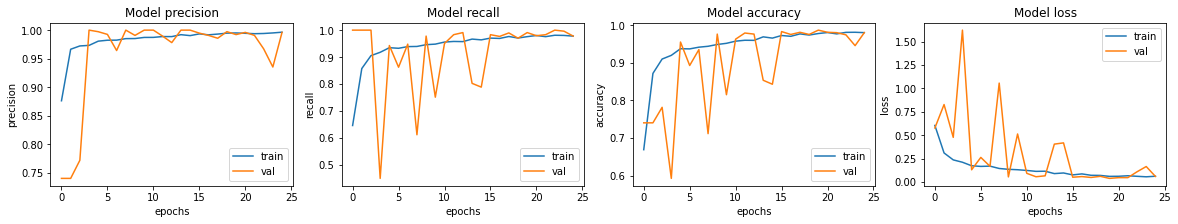

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, \nAccuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}')

39/39 [==============================] - 4s 112ms/step - loss: 0.6533 - accuracy: 0.8558 - precision: 0.8178 - recall: 0.9897
Loss: 0.6533174514770508, 
Accuracy: 0.8557692170143127, 
Precision: 0.8177965879440308, 
Recall: 0.9897435903549194


## 8. 회고
- 최초 정확도는 75%가 나왔고, 단순히 BATCH_SIZE를 32로 두 배 가량 높였을 경우에는 정확도가 63%까지 떨어졌다. 이에 따라 배치 사이즈는 16 정도가 적당하다는 것을 알게 되었고, 에폭의 경우 15 이상부터는 정확도가 어느 정도 수렴하는 것으로 보여서 초기값인 25에서 20으로 수정했다. 
- Data Augmentation의 경우 단순히 좌우반전만으로는 결과값에 크게 영향을 주지 않는 것으로 보인다. (주석 처리 하고 학습해도 비슷했기 때문에) 제대로 효과를 보려면 단순히 좌우반전이 아닌 여러 방향으로의 회전이나 확대 등의 방식을 취해야 할 것 같다. 
- Conv2D 레이어를 하나 늘렸고, 각 레이어의 차원 수를 두 배씩 늘렸다. 초기값의 경우 이미지의 특징을 잘 잡지 못하나 싶어서 이 부분을 늘렸더니 정확도가 83% 이상으로 올랐다. 위의 모든 과정을 종합했더니 최종 정확도 85.57%를 얻을 수 있었다. 
- 의료 영상 모델 특성상 recall도 중요하다. 이 역시 15 epoch 이상 진행 시 98.9%에 수렴했다. 